**Jairo Estefanía**

In [2]:
from scipy import signal
#from IPython.display import display_svg

import matplotlib
matplotlib.use('svg')
#import matplotlib.pylab as plt
import numpy as np
#init_printing(use_latex=True)
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [3]:
#Python no trae una función para conectar funciones de transferencia en serie o 
#retroalimentadas, asi que con ayuda del equipo de pybonacci creamos unas funciones.
#http://pybonacci.org/2013/10/10/teoria-de-control-en-python-con-scipy-i/
#http://pybonacci.org/2013/11/06/teoria-de-control-en-python-con-scipy-ii-control-pid/

def series(sys1, sys2):
    """Series connection of two systems.
    """
    if not isinstance(sys1, signal.lti):
        sys1 = signal.lti(*sys1)
    if not isinstance(sys2, signal.lti):
        sys2 = signal.lti(*sys2)
    num = np.polymul(sys1.num, sys2.num)
    den = np.polymul(sys1.den, sys2.den)
    sys = signal.lti(num, den)
    return sys
def feedback(plant, sensor=None):
    """Negative feedback connection of plant and sensor.
    If sensor is None, then it is assumed to be 1.
    """
    if not isinstance(plant, signal.lti):
        plant = signal.lti(*plant)
    if sensor is None:
        sensor = signal.lti([1], [1])
    elif not isinstance(sensor, signal.lti):
        sensor = signal.lti(*sensor)
    num = np.polymul(plant.num, sensor.den)
    den = np.polyadd(np.polymul(plant.den, sensor.den),
                     np.polymul(plant.num, sensor.num))
    sys = signal.lti(num, den)
    return sys


def error(plant, sensor=None, entrada=None):
    """Negative feedback connection of plant and sensor.
    If sensor is None, then it is assumed to be 1.
    """
    if not isinstance(plant, signal.lti):
        plant = signal.lti(*plant)

    if sensor is None:
        sensor = signal.lti([1], [1])
    elif not isinstance(sensor, signal.lti):
        sensor = signal.lti(*sensor)
        

    if entrada is None:
        entrada = signal.lti([1], [1])
    elif not isinstance(entrada, signal.lti):
        entrada = signal.lti(*entrada) 
 
        
        
 #   aux = np.polymul(plant.den, sensor.den)
    num = np.polymul(np.polymul(plant.den, sensor.den),entrada.num)
    den = np.polyadd(np.polymul(np.polymul(plant.den, sensor.den),entrada.den),
                     np.polymul(np.polymul(plant.num, sensor.num),entrada.den))
    sys = signal.lti(num, den)
    return sys


# De la misma manera, construimos una función para que nos devuelva el tiempo de 
# respuesta y el sobredisparo.

def tr(t, y, ys=None, margins=(0.0, 1.0)):
    """Rise time.
    Other possible margins: (0.05, 0.95), (0.1, 0.9). If no ys is given,
    then last value of y is assumed as stationary.
    """
    if ys is None:
        ys = y[-1]
    # Values between margins[0] * ys and margins[1] * ys
    mask = (y > margins[0] * ys) & (y < margins[1] * ys)
    # If response oscillates, only interested in limits of first region
    idx_change = np.nonzero(np.diff(mask))[0]
    # Initial and final indexes
    idx = idx_change[0], idx_change[1]
    # Time difference
    return t[idx[1]] - t[idx[0]]
def Ms(y, ys=None):
    """Maximum overshoot.
    Other possible margins: (0.05, 0.95), (0.1, 0.9). If no ys is given,
    then last value of y is assumed as stationary.
    """
    if ys is None:
        ys = y[-1]
    ymax = np.max(y)
    Ms = (ymax - ys) / ys
    return Ms

![Sistema](img/practica_01.svg)



| Sistema A | Sistema B |
|:-----------:|:----------:|
|$G(s) = \frac{2}{s+7} \quad H(s) = 3$ | $G(s) = \frac{5}{s(s+6)} \quad H(s) = 0.5$ |

### 1.- Obtener la respuesta tempora del sistema en cadena directa ante entrada impulso unitario (k=5)

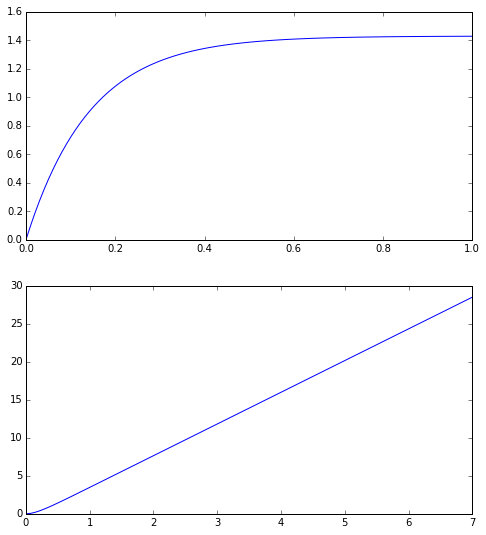

In [4]:
# Se definen las funciones de transferencia del sensor,la planta 
# y el amplificador, tanto para el sistema A,como para el sistema B.
K = ([5],[1])
H_A = ([3.],[1])
H_B = ([1],[2])
G_A = ([2],[1,7])
G_B = ([5],[1,6,0])
# Se construyen las funciones de transferencia para lazo directo.
sysA = series(K,G_A)
sysB = series(K,G_B)
# Ploteo de las salidas ante escalón unitario.
x1,y1 = signal.step2(sysA)
x2,y2 = signal.step2(sysB)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9))
ax1.plot(x1,y1)
ax2.plot(x2,y2)

Obserbamos que:
* En el sistema A sin realimentación, tenemos un error de estado constante. Es un sistema de tipo 0.
* En el sistema B, el error tiende a infinito.

#### 2.- Obtener la respuesta temporal del sistema en cadena abierta ante rampa de pendiente 3. (k=2)

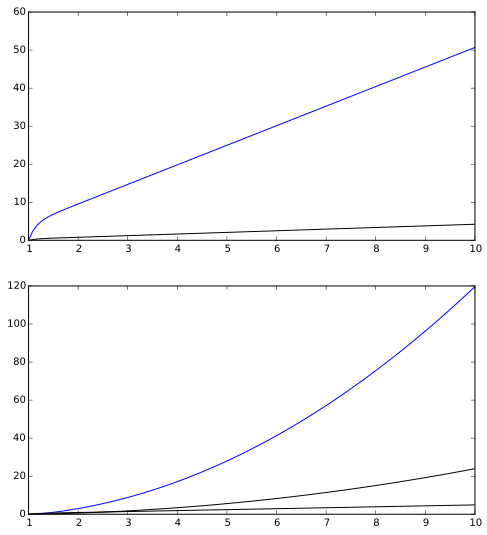

In [9]:
# Se camboa el amplificador 
K = ([2],[1])
# Y se construyen los sistemas para lazo abierto
sys_A = series(K,H_A)
sysA = series (sys_A,G_A)

sys_B = series (K,H_B)
sysB = series (sys_B,G_B)
# Se crea un vector que represente el tiempo,
T = np.linspace(1,10,100)
# Y una entrada de pendiente 3 a partir del vector T.
U=3*T
# lsim2 para plotear la salida de sistemas cuya entrada hayamos definido.
t1,x1,y1 = signal.lsim2(sysA,U,T)
t2,x2,y2 = signal.lsim2(sysB,U,T)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9))
ax1.plot(T,x1,T,y1,'k-')
ax2.plot(T,x2,T,y2,'k-')


#### 3.- Obtener la respuesta temporal del sistema en lazo cerrado ante entrada escalón de amplitud 2, asi como las características temporales de la misma (k=1)

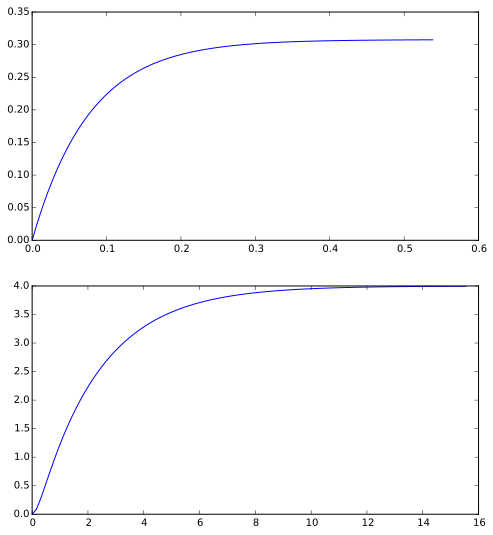

In [10]:
# Se una entrada escalón de amplitud 2.
Rs=([2],[1])
# Se construye el sistema
sys_A = feedback(G_A,H_A)
sysA = series(Rs,sys_A)
sys_B = feedback(G_B,H_B)
sysB = series(Rs,sys_B)
# Y se plotea
x1,y1 = signal.step2(sysA)
x2,y2 = signal.step2(sysB)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9))
ax1.plot(x1,y1)
ax2.plot(x2,y2)

In [11]:
TR_A_1 = tr(x1,y1) # Almacenamos los tiempos de respuesta.
TR_B_1 = tr(x2,y2)

#### 4.- Tomando k=7, analizar el efecto producido en las características temporales, para el sistema de lazo cerrado.

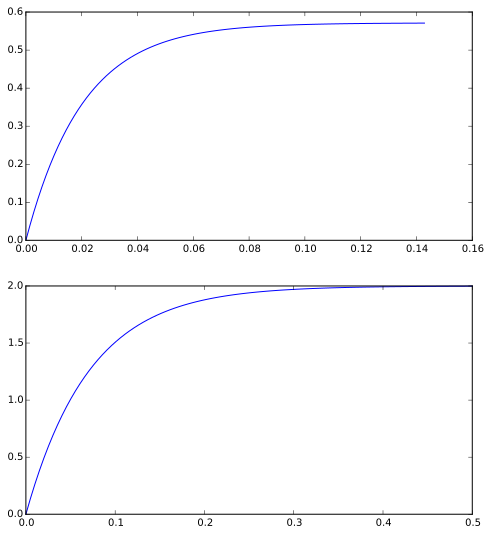

In [12]:
Rs = ([2],[1])
K = ([7],[1])
sys__A = series(K,G_A)
sys_A = feedback(sys__A,H_A)
sysA = series(Rs,sys_A)
sys__B = series(K,G_A)
sys_B = feedback(sys__B,H_B)
sysB = series(sys_B,Rs)

x1,y1 = signal.step2(sysA)
x2,y2 = signal.step2(sysB)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9))
#fig.xlim(0, 1)
plt.ylim(0,2)
ax1.plot(x1,y1)
#plt.xlim(0, 1)
#plt.ylim(0,2.2)
ax2.plot(x2,y2)


#### 5.- Estudiar el efecto que produce la variación de la amplitud en la entrada en las características temporales para el sistema de lazo cerrado.

In [13]:
TR_A_2 = tr(x1,y1)
TR_B_2 = tr(x2,y2)
print("El tiempo de respuesta para el sistema A con  K=1 es: {:0.6}".format(TR_A_1))
print("El tiempo de respuesta para el sistema A con  K=7 es: {:0.6}".format(TR_A_2))
print("El tiempo de respuesta para el sistema B con  K=1 es: {:0.6}".format(TR_B_1))
print("El tiempo de respuesta para el sistema B con  K=7 es: {:0.6}".format(TR_B_2))

El tiempo de respuesta para el sistema A con  K=1 es: 0.533023
El tiempo de respuesta para el sistema A con  K=7 es: 0.141414
El tiempo de respuesta para el sistema B con  K=1 es: 15.3817
El tiempo de respuesta para el sistema B con  K=7 es: 0.494949


#### 6.- Obtener la función de transferencia del error, respecto a la señal de referencia.

$E(s) = \frac{R(s)}{1+KG(s)H(s)}$

In [9]:
E_A = error (plant=G_A,sensor=H_A)
E_B = error (plant=G_A,sensor=H_B)

In [10]:
E_A.num

array([ 1.,  7.])

In [11]:
E_A.den

array([  1.,  13.])

In [12]:
E_B.num

array([ 1.,  7.])

In [13]:
E_B.den

array([ 1.,  8.])

Usease:

$E_A = \frac{s+7}{s+13}$

$E_B = \frac{s+1}{s+8}$

***7.- Representar la evolución temporal del sistema ante las siguientes entradas:***

* ***Impulso ***
* ***Escalón de amplitud 2***
* ***Parábola de amplitud 3***

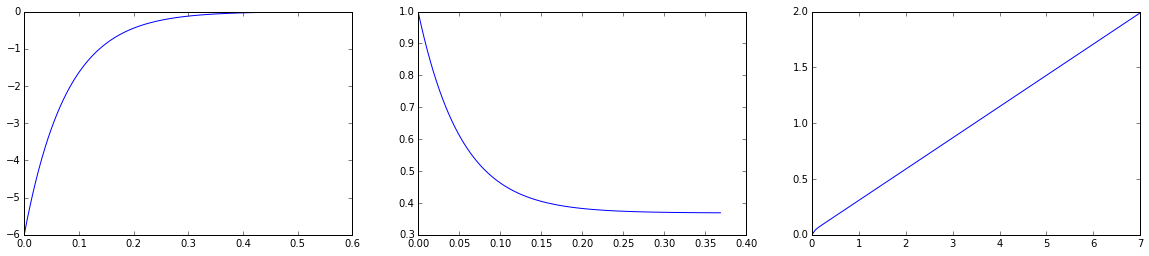

In [14]:
E_A = error (plant=G_A,sensor=H_A)
x1A,y1A = signal.impulse2(E_A)

k=signal.lti([2],[1])
planta=series(G_A,k)
E_A = error (plant=planta,sensor=H_A)
x2A,y2A = signal.step2(E_A)


k=signal.lti([3],[1])
planta=series(G_A,k)
pre_E_A = error (plant=planta,sensor=H_A)
E_A = series(pre_E_A,([1],[1,0]))
x3A,y3A = signal.step2(E_A)


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
ax1.plot(x1A,y1A)
ax2.plot(x2A,y2A)
ax3.plot(x3A,y3A)

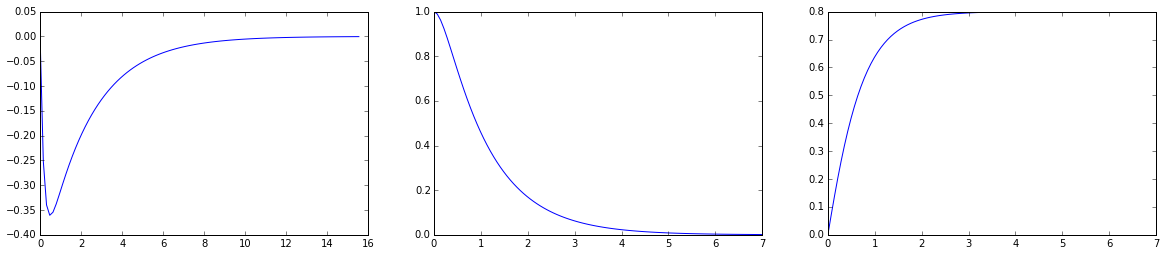

In [15]:
E_B = error (plant=G_B,sensor=H_B)
x1B,y1B = signal.impulse2(E_B)

k=signal.lti([2],[1])
planta=series(G_B,k)
E_B = error (plant=planta,sensor=H_B)
x2B,y2B = signal.step2(E_B)


k=signal.lti([3],[1])
planta=series(G_B,k)
pre_E_B = error (plant=planta,sensor=H_B)
E_B = series(pre_E_B,([1],[1,0]))
x3B,y3B = signal.step2(E_B)


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
ax1.plot(x1B,y1B)
ax2.plot(x2B,y2B)
ax3.plot(x3B,y3B)